### Get the dataset images

# Model V10
Changes compared to V9:
* Set the epoch to 100 in stead of 50

In [2]:
!git clone https://github.com/LeoEmmanuelJoint/FAA_project.git

Cloning into 'FAA_project'...
remote: Enumerating objects: 113028, done.
remote: Counting objects: 100% (34351/34351), done.
remote: Compressing objects: 100% (34318/34318), done.
remote: Total 113028 (delta 35), reused 34345 (delta 29), pack-reused 78677
Receiving objects: 100% (113028/113028), 404.05 MiB | 29.26 MiB/s, done.
Resolving deltas: 100% (11696/11696), done.
Updating files: 100% (119757/119757), done.


In [3]:
import os
import cv2
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [4]:
# Chemin vers les données d'entraînement et de test
train_data_path = "/kaggle/working/FAA_project/data/train_10000"#"/content/FAA_project/data/train"#
test_data_path = "/kaggle/working/FAA_project/data/data"#"/content/FAA_project/data/test"#

list_emotions = ["anger", "disgust", "fear", "happiness", "neutral", "sadness", "surprise"]
k_folds_val = 5
batch_size_val = 64
epoch_val = 100
number_of_labels = len(list_emotions)

## Setting the train and test dataset

Creating the dataset

In [5]:
def preprocess_data(path_data, classes, img_width=48, img_height=48, alreadyInGray=False):
    X_ = []
    y_ = []

    for category in classes:
        path_data_folder = os.path.join(path_data, category)
        class_num = classes.index(category)
        for img in os.listdir(path_data_folder):
            try:
                pathImg = os.path.join(path_data_folder, img)
                img_array = cv2.imread(pathImg, 0)
                #if not(alreadyInGray):
                    #img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
                img_array = cv2.resize(img_array, (48, 48))
                X_.append(img_array)
                y_.append(class_num)
            except Exception as e:
                print(e)
                pass

    X_ = np.array(X_, 'float32')
    y_ = np.array(y_, 'float32')

    #normalizing data between 0 and 1
    X_ -= np.mean(X_, axis=0)
    X_ /= np.std(X_, axis=0)

    X_ = X_.reshape(X_.shape[0], img_width, img_height, 1)

    print("Data shape: ", X_.shape, y_.shape)
    return(X_, y_)

In [6]:
def count_classes_occurrence(Y, classes):
    occurences = dict()
    for k in range(len(classes)):
        value = classes[k]
        occurences[value] = np.count_nonzero(Y == k)
    return(occurences)
    

In [7]:
X_train, y_train = preprocess_data(train_data_path, list_emotions, alreadyInGray=True)
X_test, y_test = preprocess_data(test_data_path, list_emotions)

train_repartition = count_classes_occurrence(y_train, list_emotions)
test_repartition = count_classes_occurrence(y_test, list_emotions)

print("Train repartition:\n",train_repartition)
print("Test repartition:\n",test_repartition)

input_shape = X_train.shape[1:]

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: pro

Data shape:  (69801, 48, 48, 1) (69801,)
Data shape:  (14000, 48, 48, 1) (14000,)
Train repartition:
 {'anger': 10000, 'disgust': 9802, 'fear': 10000, 'happiness': 10000, 'neutral': 10000, 'sadness': 10000, 'surprise': 9999}
Test repartition:
 {'anger': 2000, 'disgust': 2000, 'fear': 2000, 'happiness': 2000, 'neutral': 2000, 'sadness': 2000, 'surprise': 2000}


Create the model

Building the model based on the architecture :
https://www.nature.com/articles/s41598-022-11173-0

Help to add more layers while keeping a size tha

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D

def create_model(BN=False, show=False):
    model=Sequential()
    
    # Feature extraction layers
    
    #Layer 1
    print("1")
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same')) # Added
    model.add(Conv2D(64,kernel_size= (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same')) # Added
    if BN: model.add(BatchNormalization())
    #model.add(MaxPooling2D(pool_size=1))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
    model.add(Dropout(0.5))
    
    # Layer 2
    print("2")
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same')) # Added
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same')) # Added
    if BN: model.add(BatchNormalization())
    #model.add(MaxPooling2D(pool_size=2)) # Reduced the pooling size to limit the loss of size
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
    model.add(Dropout(0.5))

    # Layer 4
    print("4")
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same')) # Added the same padding to limit the loss of size
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same')) # Added
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same')) # Added 
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same')) # Added
    if BN: model.add(BatchNormalization())
    #model.add(MaxPooling2D(pool_size=1))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))

    # Classification layers
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(number_of_labels, activation='softmax'))

    if show: print(model.summary())
    return(model)

Using https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class
and
https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
Other metrics could be used, see : https://www.tensorflow.org/api_docs/python/tf/keras/Model and
https://keras.io/api/metrics/

In [9]:
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.metrics import AUC

def compile_model(model):
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy'])
# #categorical_crossentropy should have been used, yet it does not work

In [10]:
FERmodel = create_model(BN=True, show=True)
compile_model(FERmodel)

1
2
4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 44, 44, 64)        36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 44, 44, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 44, 44, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 64)       0         
 )                                                

Help for
* early stopping here : https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
* GridSearch: https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

Train the model on k folds

Determine the best parameters with GridSearch

In [11]:
def convert(seconds):
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
     
    return "%d:%02d:%02d" % (hour, minutes, seconds)

In [12]:
#!pip install scikeras

In [13]:
### from sklearn.model_selection import GridSearchCV
"""from scikeras.wrappers import KerasClassifier
import tensorflow as tf

def create_model4Grid():
    model = create_model(BN=True, show=True)
    compile_model(model)
    return model

# fix random seed for reproducibility
seed = 7
tf.random.set_seed(seed)

model_4Grid = KerasClassifier(model=create_model4Grid, verbose=1)
batch_size_val = [10, 20, 40, 60, 80, 100]
epochs_val = [30, 50, 75, 100]
param_grid = dict(batch_size=batch_size_val, epochs=epochs_val)
grid = GridSearchCV(estimator=model_4Grid, param_grid=param_grid, n_jobs=None, cv=5)

grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))"""

'from scikeras.wrappers import KerasClassifier\nimport tensorflow as tf\n\ndef create_model4Grid():\n    model = create_model(BN=True, show=True)\n    compile_model(model)\n    return model\n\n# fix random seed for reproducibility\nseed = 7\ntf.random.set_seed(seed)\n\nmodel_4Grid = KerasClassifier(model=create_model4Grid, verbose=1)\nbatch_size_val = [10, 20, 40, 60, 80, 100]\nepochs_val = [30, 50, 75, 100]\nparam_grid = dict(batch_size=batch_size_val, epochs=epochs_val)\ngrid = GridSearchCV(estimator=model_4Grid, param_grid=param_grid, n_jobs=None, cv=5)\n\ngrid_result = grid.fit(X_train, y_train)\n# summarize results\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\nmeans = grid_result.cv_results_[\'mean_test_score\']\nstds = grid_result.cv_results_[\'std_test_score\']\nparams = grid_result.cv_results_[\'params\']\nfor mean, stdev, param in zip(means, stds, params):\n    print("%f (%f) with: %r" % (mean, stdev, param))'

In [14]:
"""from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from time import time
import datetime

def train_val(model, X_, y_, k, classes, bs=64, ep=50):
    start_time = time()
    val_reports = []
    val_confusion_matrixes = []
    train_accuracies = []
    val_accuracies = []
    val_losses_hist = []
    val_accuracies_hist = []
    train_losses_hist = []
    train_accuracies_hist = []
    
    # Use the same function above for the validation set
    X1_train, X1_val, y1_train, y1_val = train_test_split(X_train, y_train, test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2

    print("X_train shape: {}".format(X1_train.shape))
    print("X_test shape: {}".format(X1_test.shape))
    print("y_train shape: {}".format(y1_train.shape))
    print("y_test shape: {}".format(y1_test.shape))
    print("X_val shape: {}".format(y1_train.shape))
    print("y val shape: {}".format(y1_test.shape))
    
    val_losses_hist.extend(hist.history['val_loss'])
    val_accuracies_hist.extend(hist.history['val_accuracy'])
    train_losses_hist.extend(hist.history['loss'])
    train_accuracies_hist.extend(hist.history['accuracy'])
    
    test_predictions = model.predict(X1_test)
    test_predictions = np.argmax(test_predictions, axis=1)

    test_report = classification_report(y1_test, test_predictions, target_names=classes)
    val_reports.append(test_report)

    val_confusion_matrix = confusion_matrix(y1_test, test_predictions)
    val_confusion_matrixes.append(val_confusion_matrix)

    val_accuracy = accuracy_score(y1_test, test_predictions)
    val_accuracies.append(val_accuracy)

    train_predictions = model.predict(X1_train)
    train_predictions = np.argmax(train_predictions, axis=1)
    train_accuracy = accuracy_score(y1_train, train_predictions)
    train_accuracies.append(train_accuracy)
        
    history=dict()
    history["val_reports"] = val_reports
    history["val_cf_matrixes"] = val_confusion_matrixes
    history["val_accuracies"] = val_accuracies
    history["val_losses_hist"] = val_losses_hist
    history["val_accuracies_hist"] = val_accuracies_hist
    history["train_losses_hist"] = train_losses_hist
    history["train_accuracies_hist"] = train_accuracies_hist
    
    duration = start_time - time()
    print("Training duration: " + convert(duration)))
    
    return(history)"""

'from sklearn.metrics import classification_report\nfrom sklearn.metrics import confusion_matrix\nfrom sklearn.metrics import accuracy_score\nfrom time import time\nimport datetime\n\ndef train_val(model, X_, y_, k, classes, bs=64, ep=50):\n    start_time = time()\n    val_reports = []\n    val_confusion_matrixes = []\n    train_accuracies = []\n    val_accuracies = []\n    val_losses_hist = []\n    val_accuracies_hist = []\n    train_losses_hist = []\n    train_accuracies_hist = []\n    \n    # Use the same function above for the validation set\n    X1_train, X1_val, y1_train, y1_val = train_test_split(X_train, y_train, test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2\n\n    print("X_train shape: {}".format(X1_train.shape))\n    print("X_test shape: {}".format(X1_test.shape))\n    print("y_train shape: {}".format(y1_train.shape))\n    print("y_test shape: {}".format(y1_test.shape))\n    print("X_val shape: {}".format(y1_train.shape))\n    print("y val shape: {}".format(y1_test.shap

In [15]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from time import time
import datetime

def train_kfold(model, X_, y_, k, classes, bs=64, ep=50):
    start_time = time()
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    val_reports = []
    val_reports_dict = []
    val_confusion_matrixes = []
    train_accuracies = []
    val_accuracies = []
    val_losses_hist = []
    val_accuracies_hist = []
    train_losses_hist = []
    train_accuracies_hist = []
    #es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, restore_best_weights=True, patience=50)
    
    fold = 0
    for train_index, test_index in kfold.split(X_train):
        ktrain_start = time()
        Xk_train, Xk_test = X_[train_index], X_[test_index]
        yk_train, yk_test = y_[train_index], y_[test_index]
        
        Xk_train = np.array(Xk_train)
        Xk_test = np.array(Xk_test)
        yk_train = np.array(yk_train)
        yk_test = np.array(yk_test)
        
        fold += 1
        
        print("TRAINING ON FOLD: ", fold)
        
        hist = model.fit(
            Xk_train, 
            yk_train, 
            validation_data=(Xk_test, yk_test),
            batch_size=bs, 
            epochs=ep,
            shuffle=True)#,
            #callbacks=[es])
        
        val_losses_hist.extend(hist.history['val_loss'])
        val_accuracies_hist.extend(hist.history['val_accuracy'])
        train_losses_hist.extend(hist.history['loss'])
        train_accuracies_hist.extend(hist.history['accuracy'])

        test_predictions = model.predict(Xk_test)
        
        test_predictions = np.argmax(test_predictions, axis=1)
        
        test_report = classification_report(yk_test, test_predictions, target_names=classes)
        val_reports.append(test_report)
        test_report_dict = classification_report(yk_test, test_predictions, output_dict=True, target_names=classes)
        val_reports.append(test_report)
        
        val_confusion_matrix = confusion_matrix(yk_test, test_predictions)
        val_confusion_matrixes.append(val_confusion_matrix)
        
        val_accuracy = accuracy_score(yk_test, test_predictions)
        val_accuracies.append(val_accuracy)
        
        train_predictions = model.predict(Xk_train)
        train_predictions = np.argmax(train_predictions, axis=1)
        train_accuracy = accuracy_score(yk_train, train_predictions)
        train_accuracies.append(train_accuracy)
        
        ktrain_duration = ktrain_start - time()
        print("DURATION: " + convert(ktrain_duration))
        
    history=dict()
    history["val_reports"] = val_reports
    history["val_reports_dict"] = val_reports_dict
    history["val_cf_matrixes"] = val_confusion_matrixes
    history["val_accuracies"] = val_accuracies
    history["val_losses_hist"] = val_losses_hist
    history["val_accuracies_hist"] = val_accuracies_hist
    history["train_losses_hist"] = train_losses_hist
    history["train_accuracies_hist"] = train_accuracies_hist
    
    duration = start_time - time()
    print("Training duration: " + convert(duration))
    
    return(history)

In [16]:
history = train_kfold(FERmodel, X_train, y_train, k=k_folds_val, bs=batch_size_val, ep=epoch_val, classes=list_emotions)
print(history.keys())

TRAINING ON FOLD:  1
Epoch 1/100


2023-06-25 21:09:37.275412: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


873/873 [==============================] - 35s 31ms/step - loss: 1.7580 - accuracy: 0.2959 - val_loss: 1.6850 - val_accuracy: 0.3343
Epoch 2/100
873/873 [==============================] - 24s 28ms/step - loss: 1.4891 - accuracy: 0.4093 - val_loss: 1.5279 - val_accuracy: 0.3935
Epoch 3/100
873/873 [==============================] - 24s 28ms/step - loss: 1.3656 - accuracy: 0.4612 - val_loss: 1.3275 - val_accuracy: 0.4713
Epoch 4/100
873/873 [==============================] - 24s 28ms/step - loss: 1.2822 - accuracy: 0.4970 - val_loss: 1.3816 - val_accuracy: 0.4890
Epoch 5/100
873/873 [==============================] - 25s 29ms/step - loss: 1.2097 - accuracy: 0.5270 - val_loss: 1.3282 - val_accuracy: 0.5045
Epoch 6/100
873/873 [==============================] - 26s 29ms/step - loss: 1.1489 - accuracy: 0.5519 - val_loss: 1.3020 - val_accuracy: 0.4978
Epoch 7/100
873/873 [==============================] - 24s 28ms/step - loss: 1.0881 - accuracy: 0.5779 - val_loss: 1.1027 - val_accuracy: 0.57

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



873/873 [==============================] - 25s 29ms/step - loss: 0.0346 - accuracy: 0.9898 - val_loss: 0.0231 - val_accuracy: 0.9939
Epoch 77/100
873/873 [==============================] - 24s 28ms/step - loss: 0.0387 - accuracy: 0.9882 - val_loss: 0.0326 - val_accuracy: 0.9922
Epoch 78/100
873/873 [==============================] - 24s 28ms/step - loss: 0.0344 - accuracy: 0.9897 - val_loss: 0.0288 - val_accuracy: 0.9920
Epoch 79/100
873/873 [==============================] - 24s 28ms/step - loss: 0.0390 - accuracy: 0.9885 - val_loss: 0.0225 - val_accuracy: 0.9944
Epoch 80/100
873/873 [==============================] - 24s 27ms/step - loss: 0.0364 - accuracy: 0.9892 - val_loss: 0.0284 - val_accuracy: 0.9920
Epoch 84/100
873/873 [==============================] - 25s 29ms/step - loss: 0.0332 - accuracy: 0.9898 - val_loss: 0.0316 - val_accuracy: 0.9914
Epoch 85/100
873/873 [==============================] - 24s 28ms/step - loss: 0.0346 - accuracy: 0.9894 - val_loss: 0.0281 - val_accuracy

Pour test

In [17]:
def train_model_simple(model, X_train, y_train):
    model.fit(
            X_train, 
            y_train,
            batch_size=batch_size_val, 
            epochs=3,
            shuffle=True)

Show evolution of validation loss and validation accuracy

In [18]:
import matplotlib.pyplot as plt

def show_val_metrics(history):
    # summarize history for accuracy
    plt.plot(history['train_accuracies_hist'])
    plt.plot(history['val_accuracies_hist'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history['train_losses_hist'])
    plt.plot(history['val_losses_hist'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

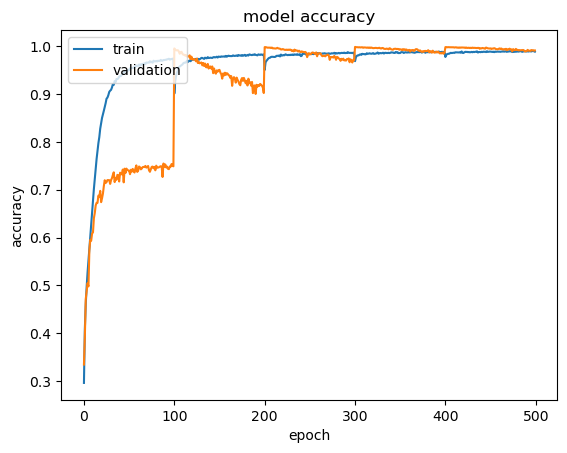

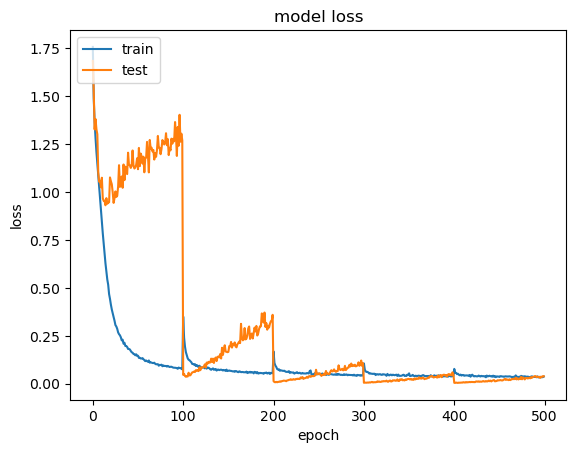

In [19]:
show_val_metrics(history)

Testing

ROC-AUC computed with https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/

Other metrics here : https://scikit-learn.org/stable/modules/model_evaluation.html#cohen-kappa

Confusion matrix here : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay.from_predictions

In [20]:
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import ConfusionMatrixDisplay

def test_model(model, X_test, y_test, classes, show=False):
    n_classes = len(classes)
    
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=classes)
    report_dict = classification_report(y_test, y_pred, output_dict=True, target_names=classes)
    cf_matrix = confusion_matrix(y_test, y_pred)
    # Compute Kappa coefficient
    kappa = cohen_kappa_score(y_test, y_pred)
    
    
    res = {
        'test_accuracy': accuracy,
        'test_report': report,
        'test_report_dict': report_dict,
        'test_cf_matrix': cf_matrix,
        'test_kappa': kappa}
    
    if show: 
        print("Confusion matrix:\n", res['test_cf_matrix'])
        print("Test report:\n", res['test_report'])
        print("Kappa: ", res['test_kappa'])
        ConfusionMatrixDisplay.from_predictions(
            y_test, 
            y_pred, 
            display_labels=np.array(classes))
    return res

438/438 [==============================] - 2s 4ms/step
Confusion matrix:
 [[1767   24   49   12   96   40   12]
 [  12 1870   34   18   24   39    3]
 [ 268  149 1320   40  105   55   63]
 [  70   19   59 1575  147   66   64]
 [  21    5   22   26 1873   41   12]
 [   1    4   11    3  111 1868    2]
 [  11    0    6    0   30   19 1934]]
Test report:
               precision    recall  f1-score   support

       anger       0.82      0.88      0.85      2000
     disgust       0.90      0.94      0.92      2000
        fear       0.88      0.66      0.75      2000
   happiness       0.94      0.79      0.86      2000
     neutral       0.78      0.94      0.85      2000
     sadness       0.88      0.93      0.91      2000
    surprise       0.93      0.97      0.95      2000

    accuracy                           0.87     14000
   macro avg       0.88      0.87      0.87     14000
weighted avg       0.88      0.87      0.87     14000

Kappa:  0.8505833333333334


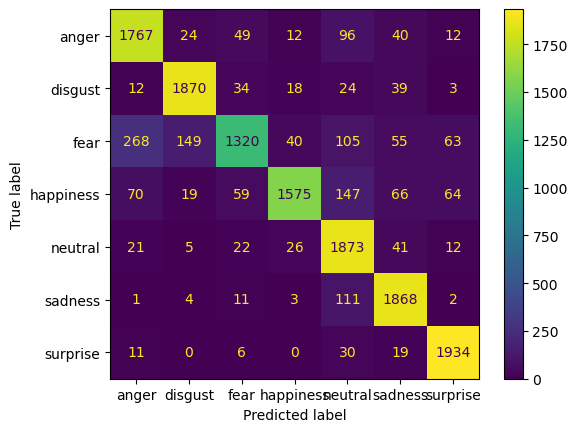

In [21]:
test_res = test_model(FERmodel, X_test, y_test, classes=list_emotions, show=True)
history.update(test_res)

## Save the model

In [22]:
from joblib import dump

def save_model_json(model, name="model_convnet"):
    model_json = model.to_json()
    with open(name + ".json", "w") as json_file:
        json_file.write(model_json)
    model.save_weights(name + ".h5")
    print("Model saved as JSON file, and weights as .h5 file.")

def save_model(model, name="model_convnet"):
    dump(model, name + ".pkl")
    print("Model saved")

In [23]:
import pickle

def save_element(x, name="element", binary=True, ext=".pkl"):
    if binary:
        mode = 'wb'
        encod='_bin'
    else:
        encod=""
        mode = 'w'
    file = open(name +encod + ext, mode)
    pickle.dump(x, file)
    file.close()
    print("File "+name+" saved")
 
# Later, open it with the following lines
#with open('Python.txt', 'rb') as f:
#    dict = pickle.load(f)

In [24]:
save_model_json(FERmodel, "FERmodel_CNN")
save_model(FERmodel, "FERmodel_CNN")
save_element(history, "history_dict")
save_element(FERmodel, "FERmodel_CNN", binary=True, ext='.pkl')

Model saved as JSON file, and weights as .h5 file.
Model saved
File history_dict saved
File FERmodel_CNN saved


In [25]:
save_element(history, "history_dict", binary=True, ext=".txt")

File history_dict saved
